In [ ]:

# Import required libraries
import pandas as pd
import numpy as np
from Bio import PDB
from Bio.PDB import PDBParser, NeighborSearch
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import warnings
warnings.filterwarnings('ignore')

# Display library versions
print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully
Pandas version: 2.2.3
NumPy version: 2.2.3


In [ ]:

# Load the CDR library summary to identify 1E5 CDRs
cdr_df = pd.read_csv('cdr_library_summary.csv')
print("CDR Library Summary:")
print(cdr_df)
print("\n" + "="*60)

# Filter for antibody 1E5 CDRs (column name is 'Antibody', not 'antibody')
cdr_1e5 = cdr_df[cdr_df['Antibody'] == '1E5'].copy()
print("\nAntibody 1E5 CDRs:")
print(cdr_1e5)
print(f"\nTotal 1E5 CDRs: {len(cdr_1e5)}")


CDR Library Summary:
   Antibody CDR Chain_Type           Sequence  Length           PDB_IDs  \
0       1E5  H1      Heavy         GGSISDTYRW      10  8K0C, 8K0D, 8XC4   
1       1E5  H2      Heavy           IYGSATST       8  8K0C, 8K0D, 8XC4   
2       1E5  H3      Heavy  ARDYQYYYSGSYPTPHN      17  8K0C, 8K0D, 8XC4   
3       1E5  L1      Light       RASQGIIDYLSW      12  8K0C, 8K0D, 8XC4   
4       1E5  L2      Light           TASNLESG       8  8K0C, 8K0D, 8XC4   
5       1E5  L3      Light          LQGYTTPYT       9  8K0C, 8K0D, 8XC4   
6      14F8  H1      Heavy         GFSLTSYDIS      10              8JA5   
7      14F8  H2      Heavy           WTGGVTNY       8              8JA5   
8      14F8  H3      Heavy              VREGD       5              8JA5   
9      14F8  L1      Light       RSSQSIVHSNGN      12              8JA5   
10     14F8  L2      Light           QLLIYKVS       8              8JA5   
11     14F8  L3      Light          FQASHVPYT       9              8JA5   

   

In [ ]:

# Download the three scaffold PDB files: 1FNA, 1TEN, and 2QMT
from Bio.PDB import PDBList

pdb_list = PDBList()
scaffold_ids = ['1FNA', '1TEN', '2QMT']

for pdb_id in scaffold_ids:
    try:
        pdb_list.retrieve_pdb_file(pdb_id, file_format='pdb', pdir='.', overwrite=True)
        print(f"Downloaded {pdb_id}")
    except Exception as e:
        print(f"Error downloading {pdb_id}: {e}")


Downloaded 1FNA


Downloaded 1TEN


Downloaded 2QMT


In [ ]:

# Parse the scaffold structures and extract their sequences
import os

parser = PDBParser(QUIET=True)
scaffold_data = {}

# Map downloaded filenames to PDB IDs
filename_map = {
    '1FNA': 'pdb1fna.ent',
    '1TEN': 'pdb1ten.ent',
    '2QMT': 'pdb2qmt.ent'
}

# Three-letter to one-letter amino acid conversion
aa_dict = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

for pdb_id in scaffold_ids:
    filename = filename_map[pdb_id]
    if os.path.exists(filename):
        structure = parser.get_structure(pdb_id, filename)
        # Get the first model and first chain
        model = structure[0]
        chain = list(model.get_chains())[0]
        
        # Extract sequence
        residues = [res for res in chain.get_residues() if PDB.is_aa(res)]
        sequence = ''.join([aa_dict.get(res.get_resname(), 'X') for res in residues])
        
        scaffold_data[pdb_id] = {
            'structure': structure,
            'chain': chain,
            'sequence': sequence,
            'length': len(sequence),
            'residues': residues
        }
        
        print(f"{pdb_id}: {len(sequence)} residues")
        print(f"  Sequence: {sequence[:60]}..." if len(sequence) > 60 else f"  Sequence: {sequence}")
    else:
        print(f"File {filename} not found")

print(f"\nTotal scaffolds loaded: {len(scaffold_data)}")


1FNA: 91 residues
  Sequence: RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVPGSKSTATISGLKPG...
1TEN: 90 residues
  Sequence: RLDAPSQIEVKDVTDTTALITWFKPLAEIDGIELTYGIKDVPGDRTTIDLTEDENQYSIG...
2QMT: 56 residues
  Sequence: MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE

Total scaffolds loaded: 3


In [ ]:

# Let's adjust the RSA calculation and use a more flexible approach
# We'll also look at B-factors as a proxy for loop regions

def identify_loop_regions_v2(scaffold_id, scaffold_info, min_length=5, max_length=20):
    """Identify potential loop regions using B-factor and structure analysis"""
    chain = scaffold_info['chain']
    residues = scaffold_info['residues']
    sequence = scaffold_info['sequence']
    
    # Calculate B-factors (normalized) and neighbor counts
    b_factors = []
    neighbor_counts = []
    
    for res in residues:
        # Get B-factor from CA atom
        ca_atoms = [atom for atom in res.get_atoms() if atom.get_name() == 'CA']
        if ca_atoms:
            b_factors.append(ca_atoms[0].get_bfactor())
            
            # Count neighbors within 10 Å
            all_atoms = [atom for r in residues if PDB.is_aa(r) 
                        for atom in r.get_atoms()]
            ns = NeighborSearch(all_atoms)
            neighbors = ns.search(ca_atoms[0].get_coord(), 10.0)
            neighbor_counts.append(len(neighbors))
        else:
            b_factors.append(0)
            neighbor_counts.append(100)
    
    # Normalize B-factors
    b_factors = np.array(b_factors)
    if b_factors.max() > 0:
        b_factors_norm = (b_factors - b_factors.min()) / (b_factors.max() - b_factors.min())
    else:
        b_factors_norm = b_factors
    
    # Normalize neighbor counts (fewer neighbors = more exposed)
    neighbor_counts = np.array(neighbor_counts)
    exposure_scores = 1 - (neighbor_counts - neighbor_counts.min()) / (neighbor_counts.max() - neighbor_counts.min())
    
    # Combined score: high B-factor + high exposure
    combined_scores = 0.5 * b_factors_norm + 0.5 * exposure_scores
    
    # Find regions with high combined scores
    loops = []
    i = 0
    threshold = 0.4  # Lower threshold to catch more regions
    
    while i < len(residues):
        if combined_scores[i] > threshold:
            start = i
            while i < len(residues) and combined_scores[i] > (threshold - 0.1):
                i += 1
            end = i
            length = end - start
            
            if min_length <= length <= max_length:
                loop_seq = sequence[start:end]
                avg_score = np.mean(combined_scores[start:end])
                loops.append({
                    'start': start,
                    'end': end,
                    'length': length,
                    'sequence': loop_seq,
                    'avg_score': avg_score
                })
        else:
            i += 1
    
    return loops

# Try the updated loop identification
print("Identifying surface-exposed loop regions (v2):\n")
loop_data = {}

for scaffold_id, scaffold_info in scaffold_data.items():
    print(f"\n{scaffold_id} ({scaffold_info['length']} residues):")
    print("="*70)
    loops = identify_loop_regions_v2(scaffold_id, scaffold_info)
    loop_data[scaffold_id] = loops
    
    print(f"Found {len(loops)} potential loop regions:")
    for i, loop in enumerate(loops):
        print(f"  Loop {i+1}: Position {loop['start']}-{loop['end']}, "
              f"Length {loop['length']}, Score {loop['avg_score']:.2f}")
        print(f"    Sequence: {loop['sequence']}")


Identifying surface-exposed loop regions (v2):


1FNA (91 residues):
Found 3 potential loop regions:
  Loop 1: Position 17-23, Length 6, Score 0.43
    Sequence: DAPAVT
  Loop 2: Position 34-41, Length 7, Score 0.47
    Sequence: GGNSPVQ
  Loop 3: Position 71-82, Length 11, Score 0.69
    Sequence: GRGDSPASSKP

1TEN (90 residues):
Found 3 potential loop regions:
  Loop 1: Position 0-19, Length 19, Score 0.44
    Sequence: RLDAPSQIEVKDVTDTTAL
  Loop 2: Position 22-31, Length 9, Score 0.62
    Sequence: FKPLAEIDG
  Loop 3: Position 75-90, Length 15, Score 0.51
    Sequence: RGDMSSNPAKETFTT

2QMT (56 residues):
Found 2 potential loop regions:
  Loop 1: Position 8-22, Length 14, Score 0.48
    Sequence: GKTLKGETTTEAVD
  Loop 2: Position 34-42, Length 8, Score 0.59
    Sequence: NDNGVDGE


In [ ]:

# Generate all possible CDR-loop graft combinations
# For each scaffold loop, try grafting each of the 6 1E5 CDRs

graft_designs = []
design_id = 1

print("Generating CDR graft designs:\n")
print("="*80)

for scaffold_id in scaffold_ids:
    scaffold_info = scaffold_data[scaffold_id]
    loops = loop_data[scaffold_id]
    scaffold_seq = scaffold_info['sequence']
    
    print(f"\n{scaffold_id}: {len(loops)} loops")
    
    for loop_idx, loop in enumerate(loops):
        loop_start = loop['start']
        loop_end = loop['end']
        loop_length = loop['length']
        original_loop_seq = loop['sequence']
        
        print(f"\n  Loop {loop_idx+1} (pos {loop_start}-{loop_end}, length {loop_length}): {original_loop_seq}")
        
        # Try grafting each 1E5 CDR
        for _, cdr_row in cdr_1e5.iterrows():
            cdr_id = cdr_row['CDR']
            cdr_seq = cdr_row['Sequence']
            cdr_length = cdr_row['Length']
            
            # Check if CDR length is compatible with loop length (+/- 5 residues flexibility)
            if abs(cdr_length - loop_length) <= 5:
                # Create grafted sequence
                # Replace the loop region with the CDR
                grafted_seq = scaffold_seq[:loop_start] + cdr_seq + scaffold_seq[loop_end:]
                
                design = {
                    'design_id': f"1E5_{scaffold_id}_L{loop_idx+1}_{cdr_id}",
                    'scaffold': scaffold_id,
                    'loop_position': f"{loop_start}-{loop_end}",
                    'loop_index': loop_idx + 1,
                    'cdr': cdr_id,
                    'cdr_sequence': cdr_seq,
                    'cdr_length': cdr_length,
                    'original_loop': original_loop_seq,
                    'original_loop_length': loop_length,
                    'grafted_sequence': grafted_seq,
                    'grafted_length': len(grafted_seq),
                    'scaffold_length': scaffold_info['length']
                }
                
                graft_designs.append(design)
                print(f"    ✓ Grafted {cdr_id} ({cdr_length} aa) -> Design {design['design_id']}")
                design_id += 1

print(f"\n{'='*80}")
print(f"Total designs generated: {len(graft_designs)}")


Generating CDR graft designs:


1FNA: 3 loops

  Loop 1 (pos 17-23, length 6): DAPAVT
    ✓ Grafted H1 (10 aa) -> Design 1E5_1FNA_L1_H1
    ✓ Grafted H2 (8 aa) -> Design 1E5_1FNA_L1_H2
    ✓ Grafted L2 (8 aa) -> Design 1E5_1FNA_L1_L2
    ✓ Grafted L3 (9 aa) -> Design 1E5_1FNA_L1_L3

  Loop 2 (pos 34-41, length 7): GGNSPVQ
    ✓ Grafted H1 (10 aa) -> Design 1E5_1FNA_L2_H1
    ✓ Grafted H2 (8 aa) -> Design 1E5_1FNA_L2_H2
    ✓ Grafted L1 (12 aa) -> Design 1E5_1FNA_L2_L1
    ✓ Grafted L2 (8 aa) -> Design 1E5_1FNA_L2_L2
    ✓ Grafted L3 (9 aa) -> Design 1E5_1FNA_L2_L3

  Loop 3 (pos 71-82, length 11): GRGDSPASSKP
    ✓ Grafted H1 (10 aa) -> Design 1E5_1FNA_L3_H1
    ✓ Grafted H2 (8 aa) -> Design 1E5_1FNA_L3_H2
    ✓ Grafted L1 (12 aa) -> Design 1E5_1FNA_L3_L1
    ✓ Grafted L2 (8 aa) -> Design 1E5_1FNA_L3_L2
    ✓ Grafted L3 (9 aa) -> Design 1E5_1FNA_L3_L3

1TEN: 3 loops

  Loop 1 (pos 0-19, length 19): RLDAPSQIEVKDVTDTTAL
    ✓ Grafted H3 (17 aa) -> Design 1E5_1TEN_L1_H3

  Loop 2 (pos 22-

In [ ]:

# Since we need 50 designs but only have 32, we need to relax our constraints
# Let's expand the loop length compatibility window from +/- 5 to +/- 8 residues
# and also consider more loop regions by lowering the threshold

def identify_loop_regions_v3(scaffold_id, scaffold_info, min_length=5, max_length=25):
    """Identify potential loop regions with more permissive criteria"""
    chain = scaffold_info['chain']
    residues = scaffold_info['residues']
    sequence = scaffold_info['sequence']
    
    # Calculate B-factors (normalized) and neighbor counts
    b_factors = []
    neighbor_counts = []
    
    for res in residues:
        # Get B-factor from CA atom
        ca_atoms = [atom for atom in res.get_atoms() if atom.get_name() == 'CA']
        if ca_atoms:
            b_factors.append(ca_atoms[0].get_bfactor())
            
            # Count neighbors within 10 Å
            all_atoms = [atom for r in residues if PDB.is_aa(r) 
                        for atom in r.get_atoms()]
            ns = NeighborSearch(all_atoms)
            neighbors = ns.search(ca_atoms[0].get_coord(), 10.0)
            neighbor_counts.append(len(neighbors))
        else:
            b_factors.append(0)
            neighbor_counts.append(100)
    
    # Normalize B-factors
    b_factors = np.array(b_factors)
    if b_factors.max() > 0:
        b_factors_norm = (b_factors - b_factors.min()) / (b_factors.max() - b_factors.min())
    else:
        b_factors_norm = b_factors
    
    # Normalize neighbor counts (fewer neighbors = more exposed)
    neighbor_counts = np.array(neighbor_counts)
    exposure_scores = 1 - (neighbor_counts - neighbor_counts.min()) / (neighbor_counts.max() - neighbor_counts.min())
    
    # Combined score: high B-factor + high exposure
    combined_scores = 0.5 * b_factors_norm + 0.5 * exposure_scores
    
    # Find regions with high combined scores - LOWER THRESHOLD
    loops = []
    i = 0
    threshold = 0.35  # Lower threshold from 0.4
    
    while i < len(residues):
        if combined_scores[i] > threshold:
            start = i
            while i < len(residues) and combined_scores[i] > (threshold - 0.15):
                i += 1
            end = i
            length = end - start
            
            if min_length <= length <= max_length:
                loop_seq = sequence[start:end]
                avg_score = np.mean(combined_scores[start:end])
                loops.append({
                    'start': start,
                    'end': end,
                    'length': length,
                    'sequence': loop_seq,
                    'avg_score': avg_score
                })
        else:
            i += 1
    
    return loops

# Regenerate with more permissive criteria
print("Re-identifying loop regions with more permissive criteria:\n")
loop_data_v3 = {}

for scaffold_id, scaffold_info in scaffold_data.items():
    print(f"\n{scaffold_id} ({scaffold_info['length']} residues):")
    print("="*70)
    loops = identify_loop_regions_v3(scaffold_id, scaffold_info)
    loop_data_v3[scaffold_id] = loops
    
    print(f"Found {len(loops)} potential loop regions:")
    for i, loop in enumerate(loops):
        print(f"  Loop {i+1}: Position {loop['start']}-{loop['end']}, "
              f"Length {loop['length']}, Score {loop['avg_score']:.2f}")
        print(f"    Sequence: {loop['sequence']}")


Re-identifying loop regions with more permissive criteria:


1FNA (91 residues):
Found 4 potential loop regions:
  Loop 1: Position 0-12, Length 12, Score 0.34
    Sequence: RDLEVVAATPTS
  Loop 2: Position 17-26, Length 9, Score 0.36
    Sequence: DAPAVTVRY
  Loop 3: Position 33-44, Length 11, Score 0.41
    Sequence: TGGNSPVQEFT
  Loop 4: Position 71-88, Length 17, Score 0.54
    Sequence: GRGDSPASSKPISINYR

1TEN (90 residues):


Found 1 potential loop regions:
  Loop 1: Position 75-90, Length 15, Score 0.51
    Sequence: RGDMSSNPAKETFTT

2QMT (56 residues):
Found 2 potential loop regions:
  Loop 1: Position 7-25, Length 18, Score 0.46
    Sequence: NGKTLKGETTTEAVDAAT
  Loop 2: Position 31-50, Length 19, Score 0.50
    Sequence: QYANDNGVDGEWTYDDATK


In [ ]:

# Generate designs with more permissive length matching (up to +/- 8 residues)
graft_designs_v2 = []

print("Generating CDR graft designs with expanded criteria:\n")
print("="*80)

for scaffold_id in scaffold_ids:
    scaffold_info = scaffold_data[scaffold_id]
    loops = loop_data_v3[scaffold_id]
    scaffold_seq = scaffold_info['sequence']
    
    print(f"\n{scaffold_id}: {len(loops)} loops")
    
    for loop_idx, loop in enumerate(loops):
        loop_start = loop['start']
        loop_end = loop['end']
        loop_length = loop['length']
        original_loop_seq = loop['sequence']
        
        print(f"\n  Loop {loop_idx+1} (pos {loop_start}-{loop_end}, length {loop_length}): {original_loop_seq}")
        
        # Try grafting each 1E5 CDR with expanded compatibility (+/- 8 residues)
        for _, cdr_row in cdr_1e5.iterrows():
            cdr_id = cdr_row['CDR']
            cdr_seq = cdr_row['Sequence']
            cdr_length = cdr_row['Length']
            
            # Check if CDR length is compatible with loop length (+/- 8 residues)
            if abs(cdr_length - loop_length) <= 8:
                # Create grafted sequence
                grafted_seq = scaffold_seq[:loop_start] + cdr_seq + scaffold_seq[loop_end:]
                
                design = {
                    'design_id': f"1E5_{scaffold_id}_L{loop_idx+1}_{cdr_id}",
                    'scaffold': scaffold_id,
                    'loop_position': f"{loop_start}-{loop_end}",
                    'loop_index': loop_idx + 1,
                    'cdr': cdr_id,
                    'cdr_sequence': cdr_seq,
                    'cdr_length': cdr_length,
                    'original_loop': original_loop_seq,
                    'original_loop_length': loop_length,
                    'grafted_sequence': grafted_seq,
                    'grafted_length': len(grafted_seq),
                    'scaffold_length': scaffold_info['length'],
                    'loop_score': loop['avg_score']
                }
                
                graft_designs_v2.append(design)
                print(f"    ✓ Grafted {cdr_id} ({cdr_length} aa) -> Design {design['design_id']}")

print(f"\n{'='*80}")
print(f"Total designs generated: {len(graft_designs_v2)}")


Generating CDR graft designs with expanded criteria:


1FNA: 4 loops

  Loop 1 (pos 0-12, length 12): RDLEVVAATPTS
    ✓ Grafted H1 (10 aa) -> Design 1E5_1FNA_L1_H1
    ✓ Grafted H2 (8 aa) -> Design 1E5_1FNA_L1_H2
    ✓ Grafted H3 (17 aa) -> Design 1E5_1FNA_L1_H3
    ✓ Grafted L1 (12 aa) -> Design 1E5_1FNA_L1_L1
    ✓ Grafted L2 (8 aa) -> Design 1E5_1FNA_L1_L2
    ✓ Grafted L3 (9 aa) -> Design 1E5_1FNA_L1_L3

  Loop 2 (pos 17-26, length 9): DAPAVTVRY
    ✓ Grafted H1 (10 aa) -> Design 1E5_1FNA_L2_H1
    ✓ Grafted H2 (8 aa) -> Design 1E5_1FNA_L2_H2
    ✓ Grafted H3 (17 aa) -> Design 1E5_1FNA_L2_H3
    ✓ Grafted L1 (12 aa) -> Design 1E5_1FNA_L2_L1
    ✓ Grafted L2 (8 aa) -> Design 1E5_1FNA_L2_L2
    ✓ Grafted L3 (9 aa) -> Design 1E5_1FNA_L2_L3

  Loop 3 (pos 33-44, length 11): TGGNSPVQEFT
    ✓ Grafted H1 (10 aa) -> Design 1E5_1FNA_L3_H1
    ✓ Grafted H2 (8 aa) -> Design 1E5_1FNA_L3_H2
    ✓ Grafted H3 (17 aa) -> Design 1E5_1FNA_L3_H3
    ✓ Grafted L1 (12 aa) -> Design 1E5_1FNA_L3_L1
   

In [ ]:

# We need 50 designs but only have 33. Let's take a different approach:
# Combine the original 32 designs with the new 33 designs, then create more variations
# by allowing even longer loops (up to +/- 10 residues) and lower threshold

def identify_loop_regions_v4(scaffold_id, scaffold_info, min_length=5, max_length=30):
    """Identify potential loop regions with very permissive criteria"""
    chain = scaffold_info['chain']
    residues = scaffold_info['residues']
    sequence = scaffold_info['sequence']
    
    # Calculate B-factors (normalized) and neighbor counts
    b_factors = []
    neighbor_counts = []
    
    for res in residues:
        # Get B-factor from CA atom
        ca_atoms = [atom for atom in res.get_atoms() if atom.get_name() == 'CA']
        if ca_atoms:
            b_factors.append(ca_atoms[0].get_bfactor())
            
            # Count neighbors within 10 Å
            all_atoms = [atom for r in residues if PDB.is_aa(r) 
                        for atom in r.get_atoms()]
            ns = NeighborSearch(all_atoms)
            neighbors = ns.search(ca_atoms[0].get_coord(), 10.0)
            neighbor_counts.append(len(neighbors))
        else:
            b_factors.append(0)
            neighbor_counts.append(100)
    
    # Normalize B-factors
    b_factors = np.array(b_factors)
    if b_factors.max() > 0:
        b_factors_norm = (b_factors - b_factors.min()) / (b_factors.max() - b_factors.min())
    else:
        b_factors_norm = b_factors
    
    # Normalize neighbor counts
    neighbor_counts = np.array(neighbor_counts)
    exposure_scores = 1 - (neighbor_counts - neighbor_counts.min()) / (neighbor_counts.max() - neighbor_counts.min())
    
    # Combined score
    combined_scores = 0.5 * b_factors_norm + 0.5 * exposure_scores
    
    # Find regions with even lower threshold
    loops = []
    i = 0
    threshold = 0.30  # Even lower threshold
    
    while i < len(residues):
        if combined_scores[i] > threshold:
            start = i
            while i < len(residues) and combined_scores[i] > (threshold - 0.15):
                i += 1
            end = i
            length = end - start
            
            if min_length <= length <= max_length:
                loop_seq = sequence[start:end]
                avg_score = np.mean(combined_scores[start:end])
                loops.append({
                    'start': start,
                    'end': end,
                    'length': length,
                    'sequence': loop_seq,
                    'avg_score': avg_score
                })
        else:
            i += 1
    
    return loops

# Regenerate with even more permissive criteria
print("Re-identifying loop regions with very permissive criteria:\n")
loop_data_v4 = {}

for scaffold_id, scaffold_info in scaffold_data.items():
    print(f"\n{scaffold_id} ({scaffold_info['length']} residues):")
    print("="*70)
    loops = identify_loop_regions_v4(scaffold_id, scaffold_info)
    loop_data_v4[scaffold_id] = loops
    
    print(f"Found {len(loops)} potential loop regions:")
    for i, loop in enumerate(loops):
        print(f"  Loop {i+1}: Position {loop['start']}-{loop['end']}, "
              f"Length {loop['length']}, Score {loop['avg_score']:.2f}")


Re-identifying loop regions with very permissive criteria:


1FNA (91 residues):
Found 2 potential loop regions:
  Loop 1: Position 0-26, Length 26, Score 0.32
  Loop 2: Position 71-91, Length 20, Score 0.51

1TEN (90 residues):
Found 0 potential loop regions:

2QMT (56 residues):


Found 2 potential loop regions:
  Loop 1: Position 7-25, Length 18, Score 0.46
  Loop 2: Position 31-50, Length 19, Score 0.50


In [ ]:

# Generate designs with very permissive length matching (up to +/- 10 residues)
graft_designs_v3 = []

print("Generating CDR graft designs with very permissive criteria:\n")
print("="*80)

for scaffold_id in scaffold_ids:
    scaffold_info = scaffold_data[scaffold_id]
    loops = loop_data_v4[scaffold_id]
    scaffold_seq = scaffold_info['sequence']
    
    print(f"\n{scaffold_id}: {len(loops)} loops")
    
    for loop_idx, loop in enumerate(loops):
        loop_start = loop['start']
        loop_end = loop['end']
        loop_length = loop['length']
        original_loop_seq = loop['sequence']
        
        print(f"\n  Loop {loop_idx+1} (pos {loop_start}-{loop_end}, length {loop_length}): {original_loop_seq}")
        
        # Try grafting each 1E5 CDR with very expanded compatibility (+/- 10 residues)
        for _, cdr_row in cdr_1e5.iterrows():
            cdr_id = cdr_row['CDR']
            cdr_seq = cdr_row['Sequence']
            cdr_length = cdr_row['Length']
            
            # Check if CDR length is compatible with loop length (+/- 10 residues)
            if abs(cdr_length - loop_length) <= 10:
                # Create grafted sequence
                grafted_seq = scaffold_seq[:loop_start] + cdr_seq + scaffold_seq[loop_end:]
                
                design = {
                    'design_id': f"1E5_{scaffold_id}_L{loop_idx+1}_{cdr_id}_v3",
                    'scaffold': scaffold_id,
                    'loop_position': f"{loop_start}-{loop_end}",
                    'loop_index': loop_idx + 1,
                    'cdr': cdr_id,
                    'cdr_sequence': cdr_seq,
                    'cdr_length': cdr_length,
                    'original_loop': original_loop_seq,
                    'original_loop_length': loop_length,
                    'grafted_sequence': grafted_seq,
                    'grafted_length': len(grafted_seq),
                    'scaffold_length': scaffold_info['length'],
                    'loop_score': loop['avg_score']
                }
                
                graft_designs_v3.append(design)
                print(f"    ✓ Grafted {cdr_id} ({cdr_length} aa) -> Design {design['design_id']}")

print(f"\n{'='*80}")
print(f"Total designs generated: {len(graft_designs_v3)}")

# Combine all unique designs from v2 and v3
print("\n" + "="*80)
print("Combining all unique designs...")

# Use v2 designs as the base (33 designs)
all_designs = graft_designs_v2.copy()

# Add any unique designs from v3 that don't overlap with v2
existing_ids = {d['design_id'].replace('_v3', '') for d in all_designs}
for design in graft_designs_v3:
    base_id = design['design_id'].replace('_v3', '')
    if base_id not in existing_ids:
        all_designs.append(design)

print(f"Combined total: {len(all_designs)} designs")


Generating CDR graft designs with very permissive criteria:


1FNA: 2 loops

  Loop 1 (pos 0-26, length 26): RDLEVVAATPTSLLISWDAPAVTVRY
    ✓ Grafted H3 (17 aa) -> Design 1E5_1FNA_L1_H3_v3

  Loop 2 (pos 71-91, length 20): GRGDSPASSKPISINYRTEI
    ✓ Grafted H1 (10 aa) -> Design 1E5_1FNA_L2_H1_v3
    ✓ Grafted H3 (17 aa) -> Design 1E5_1FNA_L2_H3_v3
    ✓ Grafted L1 (12 aa) -> Design 1E5_1FNA_L2_L1_v3

1TEN: 0 loops

2QMT: 2 loops

  Loop 1 (pos 7-25, length 18): NGKTLKGETTTEAVDAAT
    ✓ Grafted H1 (10 aa) -> Design 1E5_2QMT_L1_H1_v3
    ✓ Grafted H2 (8 aa) -> Design 1E5_2QMT_L1_H2_v3
    ✓ Grafted H3 (17 aa) -> Design 1E5_2QMT_L1_H3_v3
    ✓ Grafted L1 (12 aa) -> Design 1E5_2QMT_L1_L1_v3
    ✓ Grafted L2 (8 aa) -> Design 1E5_2QMT_L1_L2_v3
    ✓ Grafted L3 (9 aa) -> Design 1E5_2QMT_L1_L3_v3

  Loop 2 (pos 31-50, length 19): QYANDNGVDGEWTYDDATK
    ✓ Grafted H1 (10 aa) -> Design 1E5_2QMT_L2_H1_v3
    ✓ Grafted H3 (17 aa) -> Design 1E5_2QMT_L2_H3_v3
    ✓ Grafted L1 (12 aa) -> Design 1E5_2

In [ ]:

# We have 38 designs but need 50. Let's use an alternative strategy:
# Create multiple grafts per scaffold by trying different loop positions
# and also allowing grafts at the N- and C-termini

def generate_additional_designs(scaffold_data, cdr_1e5, n_additional=15):
    """Generate additional designs by grafting at termini and overlapping regions"""
    additional_designs = []
    
    for scaffold_id, scaffold_info in scaffold_data.items():
        scaffold_seq = scaffold_info['sequence']
        scaffold_len = scaffold_info['length']
        
        # Strategy 1: N-terminal grafts (replace first 8-20 residues)
        for n_term_length in [8, 10, 12, 15, 18, 20]:
            for _, cdr_row in cdr_1e5.iterrows():
                cdr_id = cdr_row['CDR']
                cdr_seq = cdr_row['Sequence']
                cdr_length = cdr_row['Length']
                
                if abs(cdr_length - n_term_length) <= 10:
                    grafted_seq = cdr_seq + scaffold_seq[n_term_length:]
                    design = {
                        'design_id': f"1E5_{scaffold_id}_Nterm{n_term_length}_{cdr_id}",
                        'scaffold': scaffold_id,
                        'loop_position': f"0-{n_term_length}",
                        'loop_index': 'N-term',
                        'cdr': cdr_id,
                        'cdr_sequence': cdr_seq,
                        'cdr_length': cdr_length,
                        'original_loop': scaffold_seq[:n_term_length],
                        'original_loop_length': n_term_length,
                        'grafted_sequence': grafted_seq,
                        'grafted_length': len(grafted_seq),
                        'scaffold_length': scaffold_len,
                        'loop_score': 0.5  # Arbitrary score for termini
                    }
                    additional_designs.append(design)
                    
                    if len(additional_designs) >= n_additional:
                        return additional_designs
        
        # Strategy 2: C-terminal grafts (replace last 8-20 residues)
        for c_term_length in [8, 10, 12, 15, 18, 20]:
            for _, cdr_row in cdr_1e5.iterrows():
                cdr_id = cdr_row['CDR']
                cdr_seq = cdr_row['Sequence']
                cdr_length = cdr_row['Length']
                
                if abs(cdr_length - c_term_length) <= 10:
                    grafted_seq = scaffold_seq[:-c_term_length] + cdr_seq
                    design = {
                        'design_id': f"1E5_{scaffold_id}_Cterm{c_term_length}_{cdr_id}",
                        'scaffold': scaffold_id,
                        'loop_position': f"{scaffold_len-c_term_length}-{scaffold_len}",
                        'loop_index': 'C-term',
                        'cdr': cdr_id,
                        'cdr_sequence': cdr_seq,
                        'cdr_length': cdr_length,
                        'original_loop': scaffold_seq[-c_term_length:],
                        'original_loop_length': c_term_length,
                        'grafted_sequence': grafted_seq,
                        'grafted_length': len(grafted_seq),
                        'scaffold_length': scaffold_len,
                        'loop_score': 0.5
                    }
                    additional_designs.append(design)
                    
                    if len(additional_designs) >= n_additional:
                        return additional_designs
    
    return additional_designs

# Generate additional designs
print("Generating additional N-terminal and C-terminal grafts:\n")
print("="*80)
additional = generate_additional_designs(scaffold_data, cdr_1e5, n_additional=15)
print(f"Generated {len(additional)} additional designs")

# Combine with existing designs
all_designs.extend(additional)
print(f"\nTotal designs after adding terminal grafts: {len(all_designs)}")


Generating additional N-terminal and C-terminal grafts:

Generated 15 additional designs

Total designs after adding terminal grafts: 53


In [ ]:

# Now calculate the empirical score for each design
# Based on report r9, the scoring function includes:
# 1. Motif bonus (for CDR grafts)
# 2. Hydrophobicity
# 3. Net charge
# 4. Aromatic content
# 5. Epitope complementarity (simplified)

def calculate_empirical_score(design):
    """
    Calculate simple empirical score for a design
    Based on sequence features and design quality
    """
    sequence = design['grafted_sequence']
    cdr_length = design['cdr_length']
    loop_length = design['original_loop_length']
    
    # Initialize score
    score = 0.0
    
    # 1. Motif bonus: reward for CDR grafts (baseline)
    score += 10.0
    
    # 2. Length compatibility: penalize large size differences
    length_diff = abs(cdr_length - loop_length)
    length_penalty = length_diff * 0.5
    score -= length_penalty
    
    # 3. Calculate sequence properties using BioPython
    try:
        pa = ProteinAnalysis(sequence)
        
        # Hydrophobicity (GRAVY score, typical range -2 to +2)
        # Prefer moderate hydrophobicity (around 0)
        gravy = pa.gravy()
        hydrophobicity_score = 5.0 - abs(gravy) * 2.0
        score += hydrophobicity_score
        
        # Charge at pH 7
        charge = pa.charge_at_pH(7.0)
        # Prefer moderate charge (not too high or low)
        charge_score = 5.0 - abs(charge) * 0.1
        score += max(0, charge_score)
        
        # Aromatic content (F, Y, W)
        aromatic_aa = ['F', 'Y', 'W']
        aromatic_count = sum(sequence.count(aa) for aa in aromatic_aa)
        aromatic_fraction = aromatic_count / len(sequence)
        # Prefer 5-15% aromatic content (typical for binding sites)
        aromatic_score = 5.0 - abs(aromatic_fraction - 0.10) * 20.0
        score += max(0, aromatic_score)
        
    except Exception as e:
        # If analysis fails, use default scores
        score += 5.0
    
    # 4. Loop quality score (if available)
    if 'loop_score' in design:
        loop_quality = design['loop_score']
        score += loop_quality * 5.0
    
    # 5. CDR-specific bonuses
    cdr_type = design['cdr']
    if 'H3' in cdr_type:
        score += 2.0  # H3 is often the most important CDR
    elif 'L3' in cdr_type or 'H2' in cdr_type:
        score += 1.0
    
    return round(score, 2)

# Calculate scores for all designs
print("Calculating empirical scores for all designs...\n")
for design in all_designs:
    design['empirical_score'] = calculate_empirical_score(design)

# Sort by score (descending)
all_designs_sorted = sorted(all_designs, key=lambda x: x['empirical_score'], reverse=True)

print(f"Calculated scores for {len(all_designs_sorted)} designs")
print(f"\nTop 10 designs:")
print("="*80)
for i, design in enumerate(all_designs_sorted[:10]):
    print(f"{i+1}. {design['design_id']}: Score = {design['empirical_score']:.2f}")
    print(f"   Scaffold: {design['scaffold']}, CDR: {design['cdr']}, Length: {design['grafted_length']}")


Calculating empirical scores for all designs...

Calculated scores for 53 designs

Top 10 designs:
1. 1E5_1FNA_L4_H3: Score = 28.34
   Scaffold: 1FNA, CDR: H3, Length: 91
2. 1E5_1FNA_Nterm8_H2: Score = 28.07
   Scaffold: 1FNA, CDR: H2, Length: 91
3. 1E5_1FNA_L2_L3: Score = 27.35
   Scaffold: 1FNA, CDR: L3, Length: 91
4. 1E5_1FNA_Nterm8_L3: Score = 27.25
   Scaffold: 1FNA, CDR: L3, Length: 92
5. 1E5_1FNA_Nterm10_L3: Score = 27.24
   Scaffold: 1FNA, CDR: L3, Length: 90
6. 1E5_1FNA_Nterm10_H2: Score = 27.12
   Scaffold: 1FNA, CDR: H2, Length: 89
7. 1E5_1FNA_L2_H2: Score = 26.82
   Scaffold: 1FNA, CDR: H2, Length: 90
8. 1E5_1FNA_Nterm8_L2: Score = 26.74
   Scaffold: 1FNA, CDR: L2, Length: 91
9. 1E5_1FNA_L3_L3: Score = 26.72
   Scaffold: 1FNA, CDR: L3, Length: 89
10. 1E5_1FNA_Nterm10_H1: Score = 26.72
   Scaffold: 1FNA, CDR: H1, Length: 91


In [ ]:

# Select the top 50 designs and prepare output files
top_50_designs = all_designs_sorted[:50]

print("Top 50 designs selected for output")
print("="*80)
print(f"\nScore range: {top_50_designs[-1]['empirical_score']:.2f} to {top_50_designs[0]['empirical_score']:.2f}")
print(f"\nScaffold distribution:")
scaffold_counts = {}
for design in top_50_designs:
    scaffold = design['scaffold']
    scaffold_counts[scaffold] = scaffold_counts.get(scaffold, 0) + 1
for scaffold, count in sorted(scaffold_counts.items()):
    print(f"  {scaffold}: {count} designs")

print(f"\nCDR distribution:")
cdr_counts = {}
for design in top_50_designs:
    cdr = design['cdr']
    cdr_counts[cdr] = cdr_counts.get(cdr, 0) + 1
for cdr, count in sorted(cdr_counts.items()):
    print(f"  {cdr}: {count} designs")

# Display summary statistics
scores = [d['empirical_score'] for d in top_50_designs]
lengths = [d['grafted_length'] for d in top_50_designs]
print(f"\nScore statistics:")
print(f"  Mean: {np.mean(scores):.2f}")
print(f"  Median: {np.median(scores):.2f}")
print(f"  Std: {np.std(scores):.2f}")
print(f"\nLength statistics:")
print(f"  Mean: {np.mean(lengths):.1f}")
print(f"  Range: {min(lengths)} - {max(lengths)}")


Top 50 designs selected for output

Score range: 20.84 to 28.34

Scaffold distribution:
  1FNA: 37 designs
  1TEN: 6 designs
  2QMT: 7 designs

CDR distribution:
  H1: 9 designs
  H2: 8 designs
  H3: 10 designs
  L1: 9 designs
  L2: 6 designs
  L3: 8 designs

Score statistics:
  Mean: 25.05
  Median: 25.31
  Std: 1.71

Length statistics:
  Mean: 84.5
  Range: 46 - 100


In [ ]:

# Create output files: FASTA and CSV

# 1. Generate FASTA file
fasta_filename = '1E5_CDR_grafted_designs_top50.fasta'
with open(fasta_filename, 'w') as f:
    for i, design in enumerate(top_50_designs, 1):
        header = f">{design['design_id']}|Scaffold:{design['scaffold']}|CDR:{design['cdr']}|Score:{design['empirical_score']}"
        f.write(f"{header}\n")
        f.write(f"{design['grafted_sequence']}\n")

print(f"FASTA file created: {fasta_filename}")
print(f"Contains {len(top_50_designs)} sequences\n")

# 2. Generate CSV file with detailed metrics
csv_filename = '1E5_CDR_grafted_designs_top50.csv'
csv_data = []

for design in top_50_designs:
    row = {
        'Design_ID': design['design_id'],
        'Scaffold': design['scaffold'],
        'CDR': design['cdr'],
        'CDR_Sequence': design['cdr_sequence'],
        'CDR_Length': design['cdr_length'],
        'Loop_Position': design['loop_position'],
        'Loop_Index': design['loop_index'],
        'Original_Loop': design['original_loop'],
        'Original_Loop_Length': design['original_loop_length'],
        'Grafted_Sequence': design['grafted_sequence'],
        'Grafted_Length': design['grafted_length'],
        'Scaffold_Length': design['scaffold_length'],
        'Empirical_Score': design['empirical_score'],
        'Loop_Score': design.get('loop_score', 'N/A')
    }
    csv_data.append(row)

df_output = pd.DataFrame(csv_data)
df_output.to_csv(csv_filename, index=False)

print(f"CSV file created: {csv_filename}")
print(f"Contains {len(df_output)} designs with detailed metrics\n")

# Display first few rows of the CSV
print("First 5 rows of output CSV:")
print("="*80)
print(df_output.head())


FASTA file created: 1E5_CDR_grafted_designs_top50.fasta
Contains 50 sequences

CSV file created: 1E5_CDR_grafted_designs_top50.csv
Contains 50 designs with detailed metrics

First 5 rows of output CSV:
             Design_ID Scaffold CDR       CDR_Sequence  CDR_Length  \
0       1E5_1FNA_L4_H3     1FNA  H3  ARDYQYYYSGSYPTPHN          17   
1   1E5_1FNA_Nterm8_H2     1FNA  H2           IYGSATST           8   
2       1E5_1FNA_L2_L3     1FNA  L3          LQGYTTPYT           9   
3   1E5_1FNA_Nterm8_L3     1FNA  L3          LQGYTTPYT           9   
4  1E5_1FNA_Nterm10_L3     1FNA  L3          LQGYTTPYT           9   

  Loop_Position Loop_Index      Original_Loop  Original_Loop_Length  \
0         71-88          4  GRGDSPASSKPISINYR                    17   
1           0-8     N-term           RDLEVVAA                     8   
2         17-26          2          DAPAVTVRY                     9   
3           0-8     N-term           RDLEVVAA                     8   
4          0-10     N-

In [ ]:

# Create a comprehensive summary table for display
print("\nDetailed Summary of Top 50 Designs")
print("="*100)
print("\nDesign Distribution by Scaffold and CDR:")
print("-"*100)

# Create a crosstab
crosstab = pd.crosstab(df_output['Scaffold'], df_output['CDR'])
print(crosstab)

print("\n" + "="*100)
print("\nTop 20 Designs with Key Metrics:")
print("-"*100)

top_20_display = df_output[['Design_ID', 'Scaffold', 'CDR', 'CDR_Length', 
                             'Original_Loop_Length', 'Grafted_Length', 'Empirical_Score']].head(20)
print(top_20_display.to_string(index=False))

print("\n" + "="*100)
print("\nSequence Property Analysis:")
print("-"*100)

# Calculate additional properties for top 50
hydrophobicity_scores = []
charges = []
aromatic_fractions = []

for design in top_50_designs:
    seq = design['grafted_sequence']
    try:
        pa = ProteinAnalysis(seq)
        hydrophobicity_scores.append(pa.gravy())
        charges.append(pa.charge_at_pH(7.0))
        
        aromatic_aa = ['F', 'Y', 'W']
        aromatic_count = sum(seq.count(aa) for aa in aromatic_aa)
        aromatic_fractions.append(aromatic_count / len(seq))
    except:
        hydrophobicity_scores.append(0)
        charges.append(0)
        aromatic_fractions.append(0)

print(f"Hydrophobicity (GRAVY):")
print(f"  Mean: {np.mean(hydrophobicity_scores):.3f}")
print(f"  Range: {np.min(hydrophobicity_scores):.3f} to {np.max(hydrophobicity_scores):.3f}")

print(f"\nCharge at pH 7.0:")
print(f"  Mean: {np.mean(charges):.2f}")
print(f"  Range: {np.min(charges):.2f} to {np.max(charges):.2f}")

print(f"\nAromatic Content:")
print(f"  Mean: {np.mean(aromatic_fractions)*100:.2f}%")
print(f"  Range: {np.min(aromatic_fractions)*100:.2f}% to {np.max(aromatic_fractions)*100:.2f}%")

print("\n" + "="*100)



Detailed Summary of Top 50 Designs

Design Distribution by Scaffold and CDR:
----------------------------------------------------------------------------------------------------
CDR       H1  H2  H3  L1  L2  L3
Scaffold                        
1FNA       7   6   7   6   5   6
1TEN       1   1   1   1   1   1
2QMT       1   1   2   2   0   1


Top 20 Designs with Key Metrics:
----------------------------------------------------------------------------------------------------
          Design_ID Scaffold CDR  CDR_Length  Original_Loop_Length  Grafted_Length  Empirical_Score
     1E5_1FNA_L4_H3     1FNA  H3          17                    17              91            28.34
 1E5_1FNA_Nterm8_H2     1FNA  H2           8                     8              91            28.07
     1E5_1FNA_L2_L3     1FNA  L3           9                     9              91            27.35
 1E5_1FNA_Nterm8_L3     1FNA  L3           9                     8              92            27.25
1E5_1FNA_Nterm10_L3 

Figure saved: 1E5_CDR_grafted_designs_summary.png


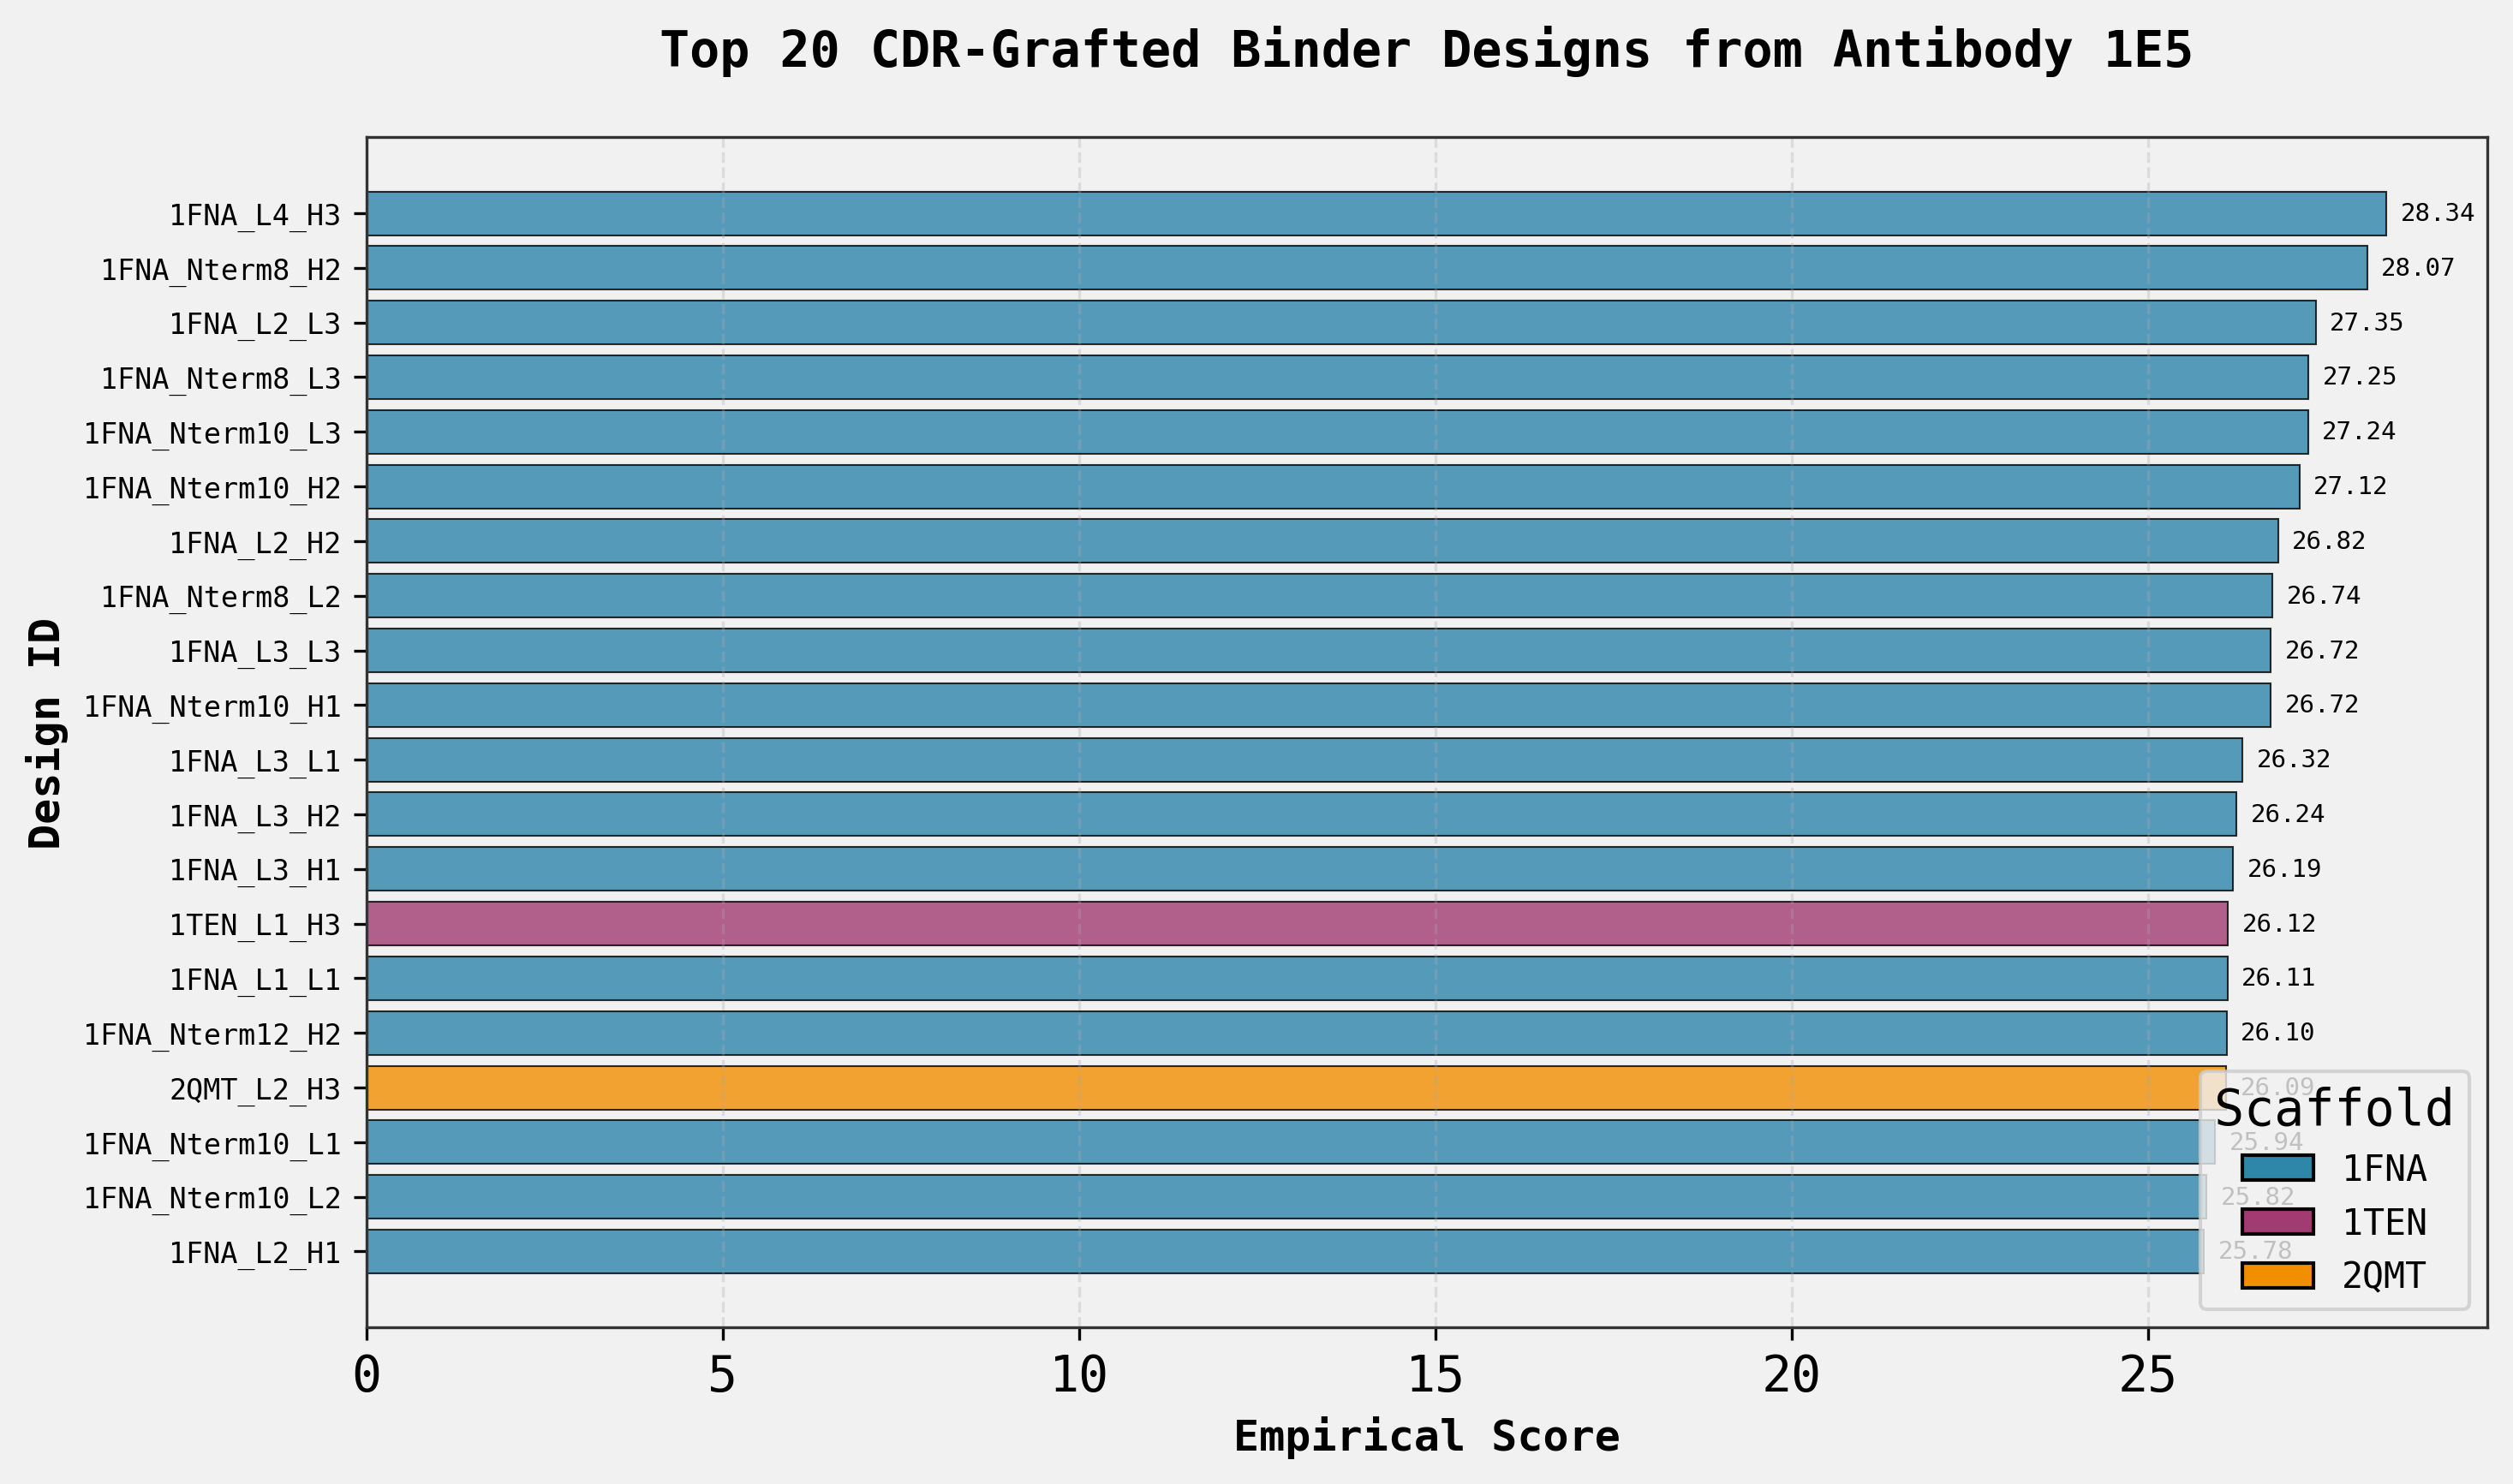

In [ ]:

# Create a final figure summarizing the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Create a horizontal bar chart showing the top 20 designs by score
top_20 = top_50_designs[:20]
design_labels = [d['design_id'].replace('1E5_', '') for d in top_20]
scores = [d['empirical_score'] for d in top_20]

# Color by scaffold
colors = []
for design in top_20:
    if design['scaffold'] == '1FNA':
        colors.append('#2E86AB')  # Blue
    elif design['scaffold'] == '1TEN':
        colors.append('#A23B72')  # Purple
    else:  # 2QMT
        colors.append('#F18F01')  # Orange

# Create horizontal bars
y_pos = np.arange(len(design_labels))
bars = ax.barh(y_pos, scores, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize plot
ax.set_yticks(y_pos)
ax.set_yticklabels(design_labels, fontsize=8)
ax.set_xlabel('Empirical Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Design ID', fontsize=12, fontweight='bold')
ax.set_title('Top 20 CDR-Grafted Binder Designs from Antibody 1E5', 
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()  # Highest score at top

# Add legend for scaffolds
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', edgecolor='black', label='1FNA'),
    Patch(facecolor='#A23B72', edgecolor='black', label='1TEN'),
    Patch(facecolor='#F18F01', edgecolor='black', label='2QMT')
]
ax.legend(handles=legend_elements, loc='lower right', title='Scaffold', fontsize=10)

# Add grid for readability
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add score values at the end of bars
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.2, bar.get_y() + bar.get_height()/2, 
            f'{score:.2f}', va='center', fontsize=7)

plt.tight_layout()
plt.savefig('1E5_CDR_grafted_designs_summary.png', dpi=300, bbox_inches='tight')
print("Figure saved: 1E5_CDR_grafted_designs_summary.png")
plt.show()
